In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras

from collections import Counter

from imblearn.over_sampling import SMOTE

from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from keras.utils.np_utils import to_categorical


from sklearn.tree import DecisionTreeClassifier

from sklearn.neighbors import KNeighborsClassifier

In [ ]:
l

Downloading...
From: https://drive.google.com/uc?id=14Dk8PRDRqwFZFVNpXiWh3QsaU23qC0cH
To: /content/arrhythmia_data.csv
100% 407k/407k [00:00<00:00, 135MB/s]


In [ ]:
df = pd.read_csv("arrhythmia_data.csv")
# membaca dataset dari "arrhythmia_data.csv" dan menyimpan ke variabel df

In [ ]:
df.info()
# print informasi tentang dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452 entries, 0 to 451
Columns: 280 entries, age to class
dtypes: float64(120), int64(155), object(5)
memory usage: 988.9+ KB


In [ ]:
df.describe()
# generate statistik deskriptif pada dataframe
# seperti nilai mean, standard deviasi, minimum, kuartil, dan maksimum

,age,sex,height,weight,qrs_duration,p-r_interval,q-t_interval,t_interval,p_interval,qrs,...,v6_ampl_q_wave,v6_ampl_r_wave,v6_ampl_s_wave,v6_ampl_r_apost_wave,v6_ampl_s_apost_wave,v6_ampl_p_wave,v6_ampl_t_wave,v6_qrsa,v6_qrsta,class
count,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,...,452.000000,452.000000,452.000000,452.000000,452.0,452.000000,452.000000,452.000000,452.000000,452.000000
mean,46.471239,0.550885,166.188053,68.170354,88.920354,155.152655,367.207965,169.949115,90.004425,33.676991,...,-0.278982,9.048009,-1.457301,0.003982,0.0,0.514823,1.222345,19.326106,29.473230,3.880531
std,16.466631,0.497955,37.170340,16.590803,15.364394,44.842283,33.385421,35.633072,25.826643,45.431434,...,0.548876,3.472862,2.002430,0.050118,0.0,0.347531,1.426052,13.503922,18.493927,4.407097
min,0.000000,0.000000,105.000000,6.000000,55.000000,0.000000,232.000000,108.000000,0.000000,-172.000000,...,-4.100000,0.000000,-28.600000,0.000000,0.0,-0.800000,-6.000000,-44.200000,-38.600000,1.000000
25%,36.000000,0.000000,160.000000,59.000000,80.000000,142.000000,350.000000,148.000000,79.000000,3.750000,...,-0.425000,6.600000,-2.100000,0.000000,0.0,0.400000,0.500000,11.450000,17.550000,1.000000
50%,47.000000,1.000000,164.000000,68.000000,86.000000,157.000000,367.000000,162.000000,91.000000,40.000000,...,0.000000,8.800000,-1.100000,0.000000,0.0,0.500000,1.350000,18.100000,27.900000,1.000000
75%,58.000000,1.000000,170.000000,79.000000,94.000000,175.000000,384.000000,179.000000,102.000000,66.000000,...,0.000000,11.200000,0.000000,0.000000,0.0,0.700000,2.100000,25.825000,41.125000,6.000000
max,83.000000,1.000000,780.000000,176.000000,188.000000,524.000000,509.000000,381.000000,205.000000,169.000000,...,0.000000,23.600000,0.000000,0.800000,0.0,2.400000,6.000000,88.800000,115.900000,16.000000


Pre Processing


In [ ]:
# menghapus data yang memiliki "class" (2, 3, 4, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16)
# memfilter dataframe berdasarkan nilai kolom "class" dan menghapus barisnya
columnIndex = df[(df["class"].isin([2,3,4,7,8,9,10,11,12,13,14,15,16]))].index
df.drop(columnIndex, inplace=True)

# modifikasi label "class" dengan meng-assign nilai baru ke classes
df.loc[df["class"] == 1, "class"] = 0
df.loc[df["class"] == 5, "class"] = 1
df.loc[df["class"] == 6, "class"] = 2

In [ ]:
# menghapus nilai duplikat dari dataframe
df = df.drop_duplicates()

In [ ]:
# mengganti nilai yang hilang ("?") dan diganti ke NaN (Not a Number)
df.replace('?', np.NaN, inplace=True)

In [ ]:
# mengganti nilai yang hilang tadi dengan nilai median
# menggunakan SimpleImputer dari scikit-learn
imp_mean = SimpleImputer(missing_values=np.NaN, strategy='median')
imputer = imp_mean.fit(df)

df_imp = imputer.transform(df)
df = pd.DataFrame(df_imp, columns=df.columns)

In [ ]:
# hanya memilih kolom yang relevan untuk analisis lebih detil
df_column_correlated_definition = [
    'sex', 'qrs', 'p-r_interval', 'q-t_interval', 't_interval', 'p_interval', 'bpm',
    'd1_ampl_p_wave', 'd1_ragged_p', 'd1_qrsa',
    'd2_ampl_p_wave', 'd2_qrsa',
    'd3_ampl_p_wave', 'd3_qrsa',
    'avr_ampl_p_wave', 'avr_qrsa',
    'avr_ragged_t',
    'avl_ampl_p_wave', 'avl_qrsa',
    'avf_ampl_p_wave', 'avf_diphasic_derivation_p_wave', 'avf_qrsa',
    'v6_ragged_p',
    'class'
]

df = df[df_column_correlated_definition]

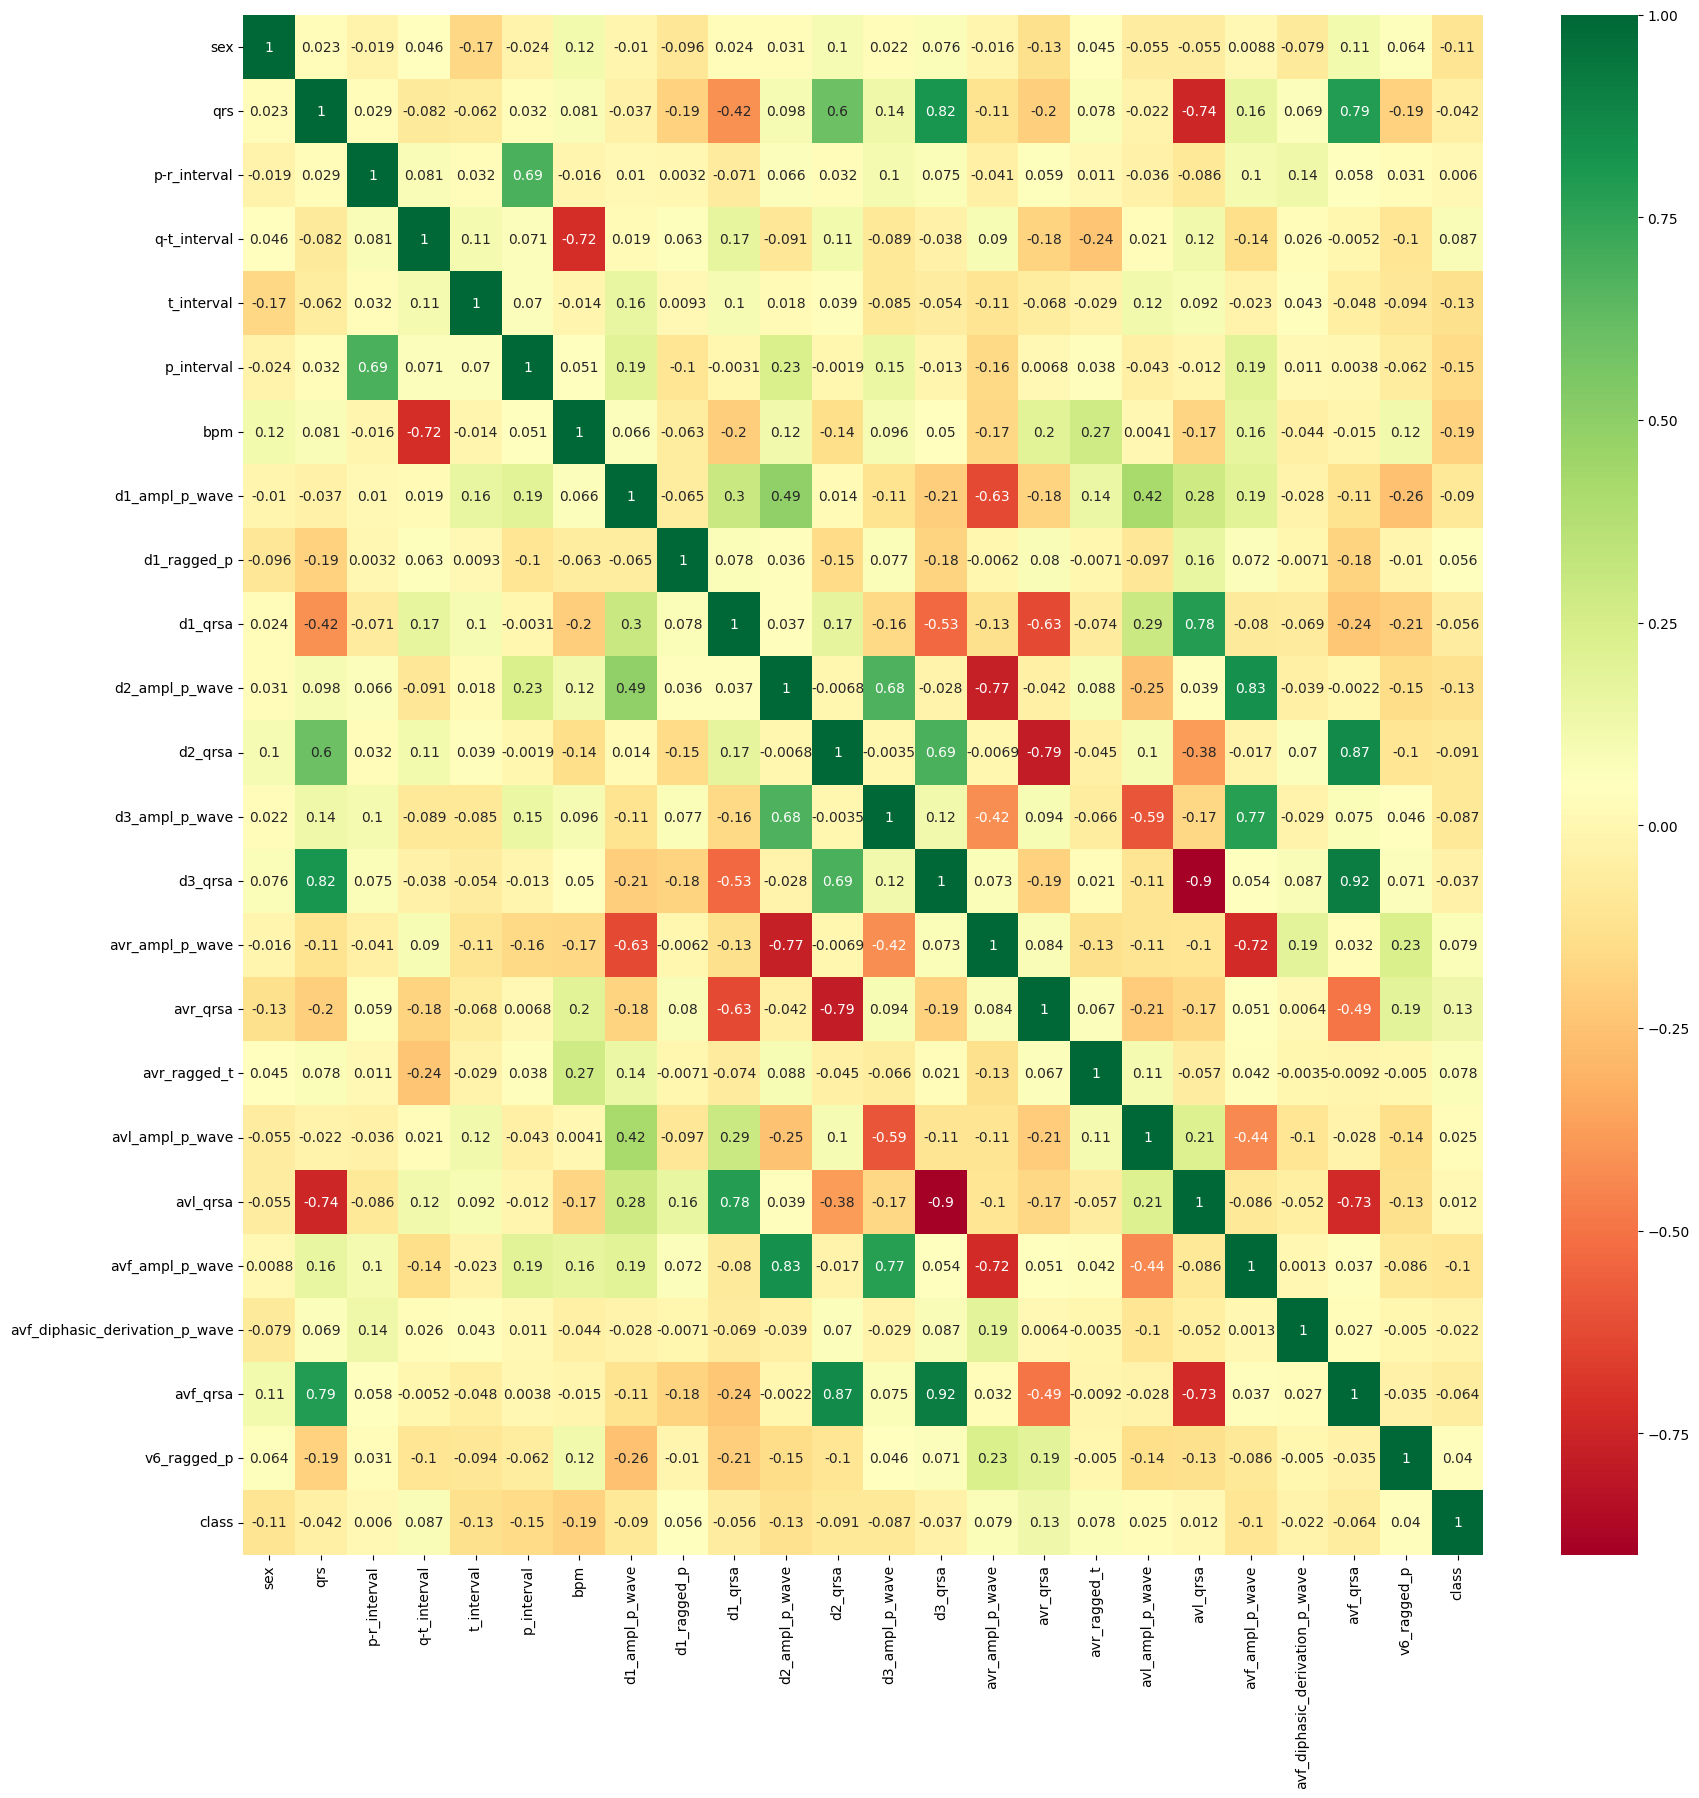

In [ ]:
# komputasi matriks korelasi dataframe
corrmat = df.corr()
# membuat heatmap dari matriks korelasi menggunakan Seaborn
plt.figure(figsize=(20,20))
g = sns.heatmap(df[corrmat.index].corr(), annot=True, cmap="RdYlGn")

In [ ]:
# mengambil sampel dari tiap class untuk set test
normal = df.loc[df['class'] == 0].sample(n=15)
tachycardia = df.loc[df['class'] == 1].sample(n=2)
bradycardia = df.loc[df['class'] == 2].sample(n=3)

# gabungkan sampel tersebut menjadi satu dataframe
df_test = pd.concat([normal, tachycardia, bradycardia])

# menghapus sampel dari test set dari dataframe utama
df = pd.concat([df, df_test]).drop_duplicates(keep=False)

In [ ]:
# pisahkan atribut dan label data dari main dataset
df_data = df.drop("class", axis="columns")
df_class = df["class"]

# pisahkan atribut dan label data dari test dataset
df_test_data = df_test.drop("class", axis="columns")
df_test_class = df_test["class"]

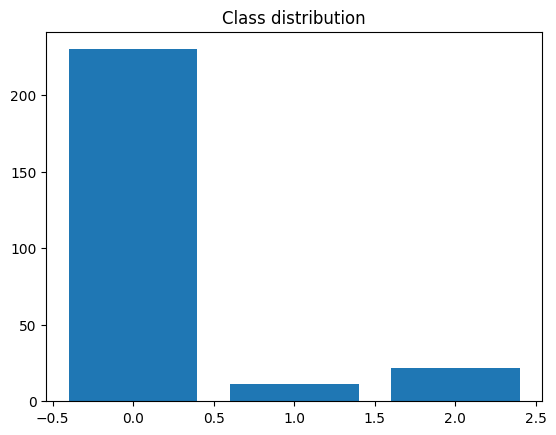

In [ ]:
# enkode label class menggunakan LabelEncoder
y = LabelEncoder().fit_transform(df_class)

# jelaskan distribusi class
counter = Counter(y)

# plot distribusi
plt.title("Class distribution")
plt.bar(counter.keys(), counter.values())
plt.show()

In [ ]:
# jalankan oversample untuk seimbangkan class, hanya oversample tachycardia dan bradycardia
strategy = {1:260, 2:230}
oversample = SMOTE(sampling_strategy=strategy, k_neighbors=4)
df_data, df_class = oversample.fit_resample(df_data, df_class)

/usr/local/lib/python3.10/dist-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (260) in class 1 will be larger than the number of samples in the majority class (class #0.0 -> 230)
  warnings.warn(


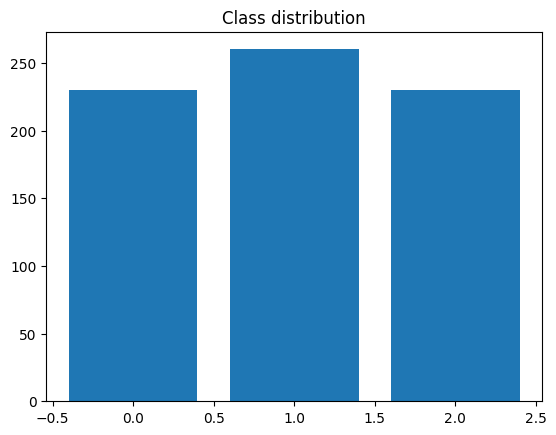

In [ ]:
#enkode label class setelah oversampling
y = LabelEncoder().fit_transform(df_class)

# jelaskan distribusi class
counter = Counter(y)

# plot distribusi
plt.title("Class distribution")
plt.bar(counter.keys(), counter.values())
plt.show()

Data Splitting


In [ ]:
# Konversi label class ke categorical form menggunakan one-hot encoding
df_class_cat = to_categorical(df_class)

In [ ]:
# Pisahkan data ke training and validation sets
X_train, X_validation, y_train, y_validation = train_test_split(df_data, df_class_cat, test_size = 0.2, shuffle = True)

In [ ]:
# Skala training, validation, and test data menggunakan StandardScaler
sc = StandardScaler()
X_train = pd.DataFrame(sc.fit_transform(X_train))
X_validation = pd.DataFrame(sc.transform(X_validation))
df_test_data = pd.DataFrame(sc.transform(df_test_data))

In [ ]:
# Print panjang dari variabel X_train dan X_validation
print(f"Train data: {len(X_train)}")
print(f"Validation data: {len(X_validation)}")

Train data: 576
Validation data: 144


Model Decision Tree

In [ ]:
#  Buat parameter grid untuk hyperparameter tuning
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 4, 10, None],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3]
}

In [ ]:
# Buat Decision Tree classifier
dt_classifier = DecisionTreeClassifier()
# Lakukan GridSearchCV untuk hyperparameter tuning dan cross-validation
grid_search = GridSearchCV(dt_classifier, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Cari best estimator dari hasil GridSearchV
best_dt_classifier = grid_search.best_estimator_

# Buat prediksi dari validation set menggunakan best estimator
y_val_pred = best_dt_classifier.predict(X_validation)

# Menghitung akurasi dari model validation set
val_accuracy = accuracy_score(y_validation, y_val_pred)
print("Validation Accuracy:", val_accuracy)

# Print classification report dari model validation set
print(classification_report(y_validation, y_val_pred))

Validation Accuracy: 0.9861111111111112
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        36
           1       0.98      1.00      0.99        52
           2       0.98      1.00      0.99        56

   micro avg       0.99      0.99      0.99       144
   macro avg       0.99      0.98      0.98       144
weighted avg       0.99      0.99      0.99       144
 samples avg       0.99      0.99      0.99       144



Test Model

In [ ]:
# Konversi label kelas dari test set ke categorical form
df_test_class_cat = to_categorical(df_test_class)

In [ ]:
# Buat prediksi untuk test set menggunakan Decision Tree model
y_test_pred = best_dt_classifier.predict(df_test_data)
# Kalkulasi akurasi dari model data test set
test_accuracy = accuracy_score(df_test_class_cat, y_test_pred)
print("Test Accuracy:", val_accuracy)
print(classification_report(df_test_class_cat, y_test_pred))

Test Accuracy: 0.9861111111111112
              precision    recall  f1-score   support

           0       1.00      0.93      0.97        15
           1       1.00      0.50      0.67         2
           2       0.75      1.00      0.86         3

   micro avg       0.95      0.90      0.92        20
   macro avg       0.92      0.81      0.83        20
weighted avg       0.96      0.90      0.92        20
 samples avg       0.90      0.90      0.90        20



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


kNN Model

In [ ]:
# Grid parameter untuk tuning hyperparameter

param_grid = {
    'n_neighbors': [2, 5, 10],
    'weights': ['uniform', 'distance'],
    'p': [1, 2, 3]
}

In [ ]:
# Buat kNN classifier
knn_classifier = KNeighborsClassifier()

# Lakukan GridSearchCV untuk hyperparameter tuning
grid_search = GridSearchCV(knn_classifier, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Cari best estimator dari hasil GridSearchV
best_knn_classifier = grid_search.best_estimator_


In [ ]:
# Buat prediksi dari validation set menggunakan best estimator
y_val_pred = best_knn_classifier.predict(X_validation)

# Menghitung akurasi dari model validation set
val_accuracy = accuracy_score(y_validation, y_val_pred)
print("Validation Accuracy:", val_accuracy)

# Print classification report dari model validation set
print(classification_report(y_validation, y_val_pred))

Validation Accuracy: 0.9444444444444444
              precision    recall  f1-score   support

           0       1.00      0.78      0.88        36
           1       0.91      1.00      0.95        52
           2       0.95      1.00      0.97        56

   micro avg       0.94      0.94      0.94       144
   macro avg       0.95      0.93      0.93       144
weighted avg       0.95      0.94      0.94       144
 samples avg       0.94      0.94      0.94       144



Test Model

In [ ]:
# Konversi label kelas dari test set ke categorical form
df_test_class_cat = to_categorical(df_test_class)

In [ ]:
# Buat prediksi untuk test set menggunakan kNN model
y_test_pred = best_knn_classifier.predict(df_test_data)
# Kalkulasi akurasi dari model data test set
test_accuracy = accuracy_score(df_test_class_cat, y_test_pred)
# Print classification report dari model test set
print("Test Accuracy:", val_accuracy)
print(classification_report(df_test_class_cat, y_test_pred))

Test Accuracy: 0.9444444444444444
              precision    recall  f1-score   support

           0       0.86      0.80      0.83        15
           1       0.50      0.50      0.50         2
           2       0.50      0.67      0.57         3

   micro avg       0.75      0.75      0.75        20
   macro avg       0.62      0.66      0.63        20
weighted avg       0.77      0.75      0.76        20
 samples avg       0.75      0.75      0.75        20



In [ ]:
Test Model